In [1]:
def create_column(component_system):
    column = LumpedRateModelWithoutPores(component_system, name='column')
    column.length = 0.014
    column.total_porosity = 0.5
    column.diameter = 0.01
    column.axial_dispersion = 5.75e-7
    return column

def create_pipes(component_system):
    pipe1 = TubularReactor(component_system, name="pipe1")
    pipe1.length = 0.1
    pipe1.diameter = 0.001
    pipe1.axial_dispersion = 6e-6
    pipe1.discretization.ncol = 50
    
    pipe2 = TubularReactor(component_system, name="pipe2")
    pipe2.length = 0.02
    pipe2.diameter = 0.001
    pipe2.axial_dispersion = 6e-6
    pipe2.discretization.ncol = 50
    
    pipe3 = TubularReactor(component_system, name="pipe3")
    pipe3.length = 0.1
    pipe3.diameter = 0.001
    pipe3.axial_dispersion = 6e-6
    pipe3.discretization.ncol = 50
    return pipe1, pipe2, pipe3

def add_noise(array):
    noise = np.random.rand(*array.shape) * 0.05 - 0.025
    array = array +  array.max(axis=0) * noise
    return array
    

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from CADETProcess.processModel import ComponentSystem
from CADETProcess.processModel import FlowSheet
from CADETProcess.processModel import Inlet, TubularReactor, LumpedRateModelWithoutPores, Outlet
from CADETProcess.processModel import Process
from CADETProcess.processModel import StericMassAction
from CADETProcess.simulator import Cadet
component_system = ComponentSystem(['Salt', 'A', "B", "C"])

# Binding Model
binding_model = StericMassAction(component_system)
binding_model.is_kinetic = True
binding_model.adsorption_rate = [0, 2.3e-5, 5.59e-1, 3.5e-3]
binding_model.desorption_rate = [0, 1, 1, 1]
binding_model.characteristic_charge = [0, 6.9, 2.3, 5.8]
binding_model.steric_factor = [0, 10, 10.6, 11.83]
binding_model.capacity = 1.2e3

column = create_column(component_system)

pipe1, pipe2, pipe3 = create_pipes(component_system)

column.binding_model = binding_model

column.q = [50, 0, 0, 0]
column.c = [50, 0, 0, 0]
pipe1.c = [50, 0, 0, 0]
pipe2.c = [50, 0, 0, 0]

volumetric_flow_rate = 1.67e-8

inlet = Inlet(component_system, name='inlet')
inlet.flow_rate = volumetric_flow_rate

outlet = Outlet(component_system, name='outlet')

# Flow Sheet
flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(inlet, feed_inlet=True)
flow_sheet.add_unit(pipe1)
flow_sheet.add_unit(column)
flow_sheet.add_unit(pipe2)
flow_sheet.add_unit(pipe3)
flow_sheet.add_unit(outlet, product_outlet=True)

flow_sheet.add_connection(inlet, pipe1)
flow_sheet.add_connection(pipe1, column)
flow_sheet.add_connection(column, pipe2)
flow_sheet.add_connection(pipe2, pipe3)
flow_sheet.add_connection(pipe3, outlet)



3.9656553268432617


<Axes: xlabel='time [s]'>

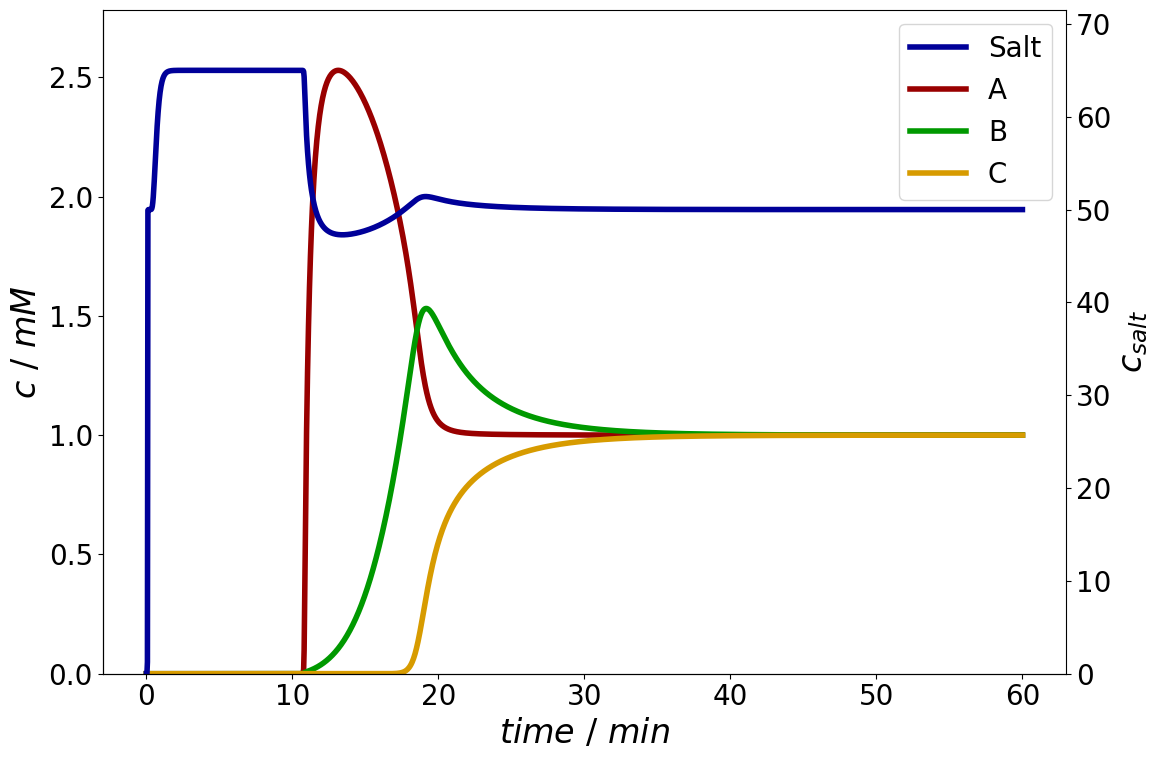

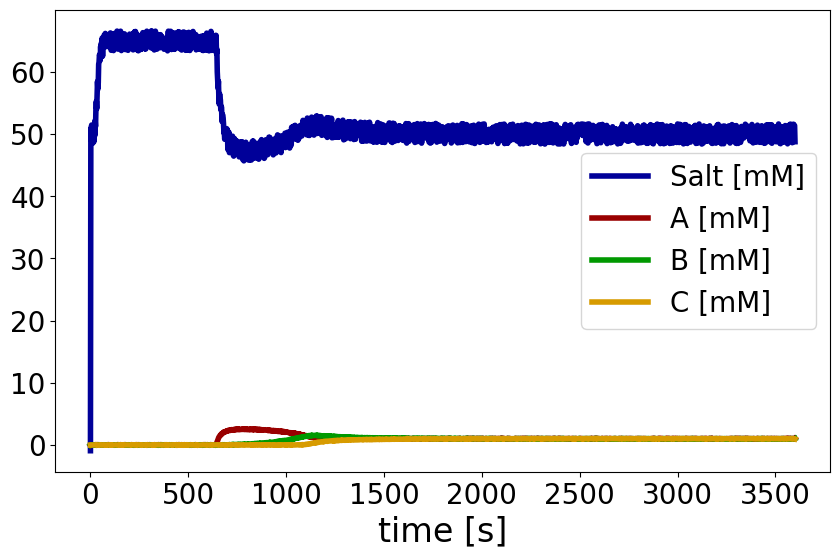

In [8]:
# Process
process = Process(flow_sheet, 'batch elution')

process.cycle_time = 60 * 60

c_salt_load = 50
c_load = [c_salt_load, 1, 1, 1]

process.add_event('load', 'flow_sheet.inlet.c', c_load, 0)

simulator = Cadet()
simulator.time_resolution = 2


simulation_results = simulator.simulate(process)
print(simulation_results.time_elapsed)

from CADETProcess.plotting import SecondaryAxis

sec = SecondaryAxis()
sec.components = ['Salt']
sec.y_label = '$c_{salt}$'

simulation_results.solution.outlet.outlet.plot(secondary_axis=sec)
import matplotlib.pyplot as plt

plt.tight_layout()


time = simulation_results.solution.outlet.outlet.time
concentrations = simulation_results.solution.pipe2.outlet.solution
salt = simulation_results.solution.outlet.outlet.solution

concentrations = add_noise(concentrations)
salt = add_noise(salt)
concentrations[0, :] = salt[0, :]

df = pd.DataFrame(data=concentrations, index=time, columns= ["Salt [mM]", "A [mM]", "B [mM]", "C [mM]"] )
df.index.name = "time [s]"
df.to_excel(f"experimental_data/breakthrough.xlsx")
plt.figure()
plt.plot(time, concentrations[:, 1:])

1.1403391361236572


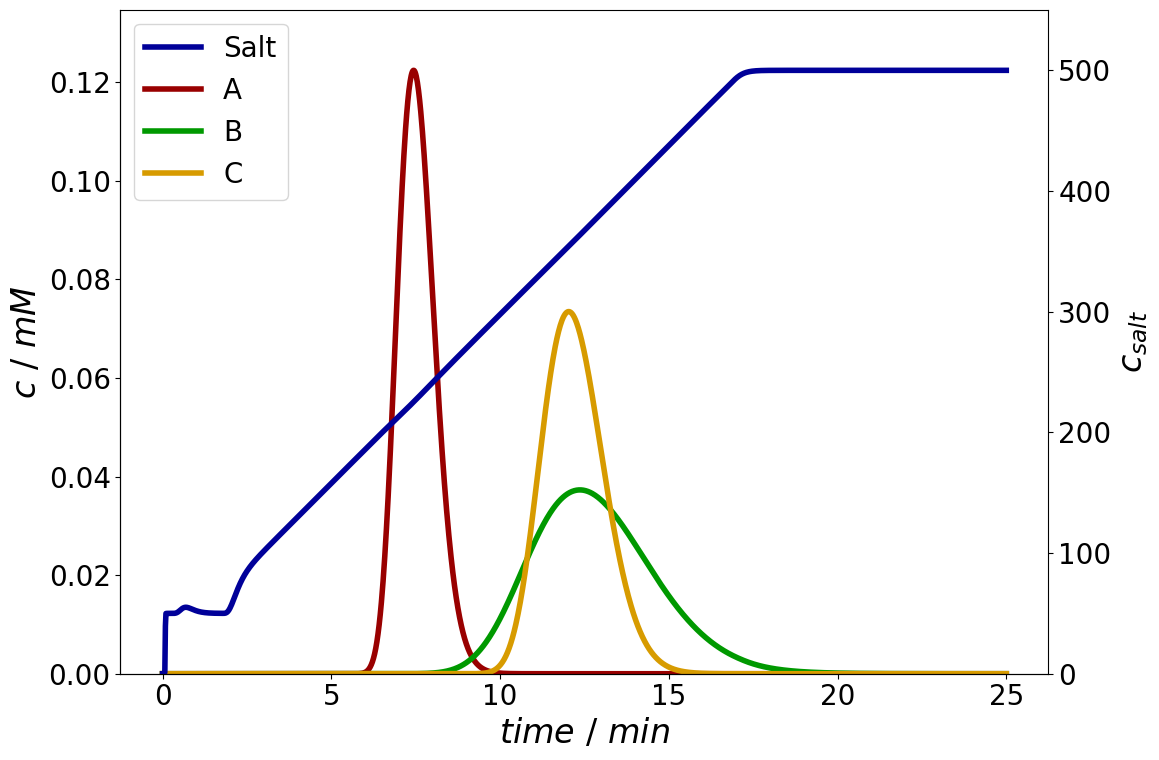

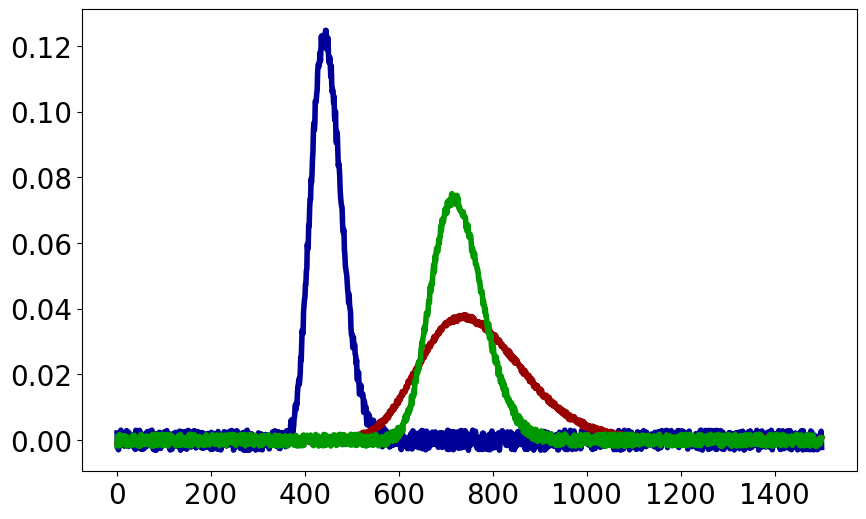

In [6]:
# Process
process = Process(flow_sheet, 'batch elution')

c_salt_load = 50
c_salt_gradient1_start = 80
c_salt_gradient1_end = 500
gradient_cv = 15
duration_gradient1 = gradient_cv * 60
process.cycle_time = duration_gradient1 + 600
t_gradient1_start = 90
t_gradient1_end = 90 + duration_gradient1
t_start_wash = 10
gradient_1_slope = (c_salt_gradient1_end - c_salt_gradient1_start)/(duration_gradient1)

c_load = [c_salt_load, 1, 1, 1]

c_wash = [c_salt_load, 0, 0, 0]

c_gradient1_poly = [
    [c_salt_gradient1_start, gradient_1_slope, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
]

process.add_duration("grad1_duration", duration_gradient1)

process.add_event('load', 'flow_sheet.inlet.c', c_load, 0)
process.add_event('wash', 'flow_sheet.inlet.c', c_wash, t_start_wash)
process.add_event('grad1_start', 'flow_sheet.inlet.c', c_gradient1_poly, t_gradient1_start)
process.add_event('grad1_end', 'flow_sheet.inlet.c', [c_salt_gradient1_end, 0, 0, 0], t_gradient1_end)

simulator = Cadet()
simulator.time_resolution = 1 

# process.plot_events()

simulation_results = simulator.simulate(process)
print(simulation_results.time_elapsed)

from CADETProcess.plotting import SecondaryAxis

sec = SecondaryAxis()
sec.components = ['Salt']
sec.y_label = '$c_{salt}$'

simulation_results.solution.outlet.outlet.plot(secondary_axis=sec)
import matplotlib.pyplot as plt

plt.tight_layout()

time = simulation_results.solution.outlet.outlet.time
concentrations = simulation_results.solution.pipe2.outlet.solution
salt = simulation_results.solution.outlet.outlet.solution

concentrations = add_noise(concentrations)
salt = add_noise(salt)
concentrations[0, :] = salt[0, :]

df = pd.DataFrame(data=concentrations, index=time, columns= ["Salt [mM]", "A [mM]", "B [mM]", "C [mM]"] )
df.index.name = "time [s]"
df.to_excel(f"experimental_data/{gradient_cv}cv_gradient.xlsx")
plt.figure()
plt.plot(time, concentrations[:, 1:])

1.048557996749878


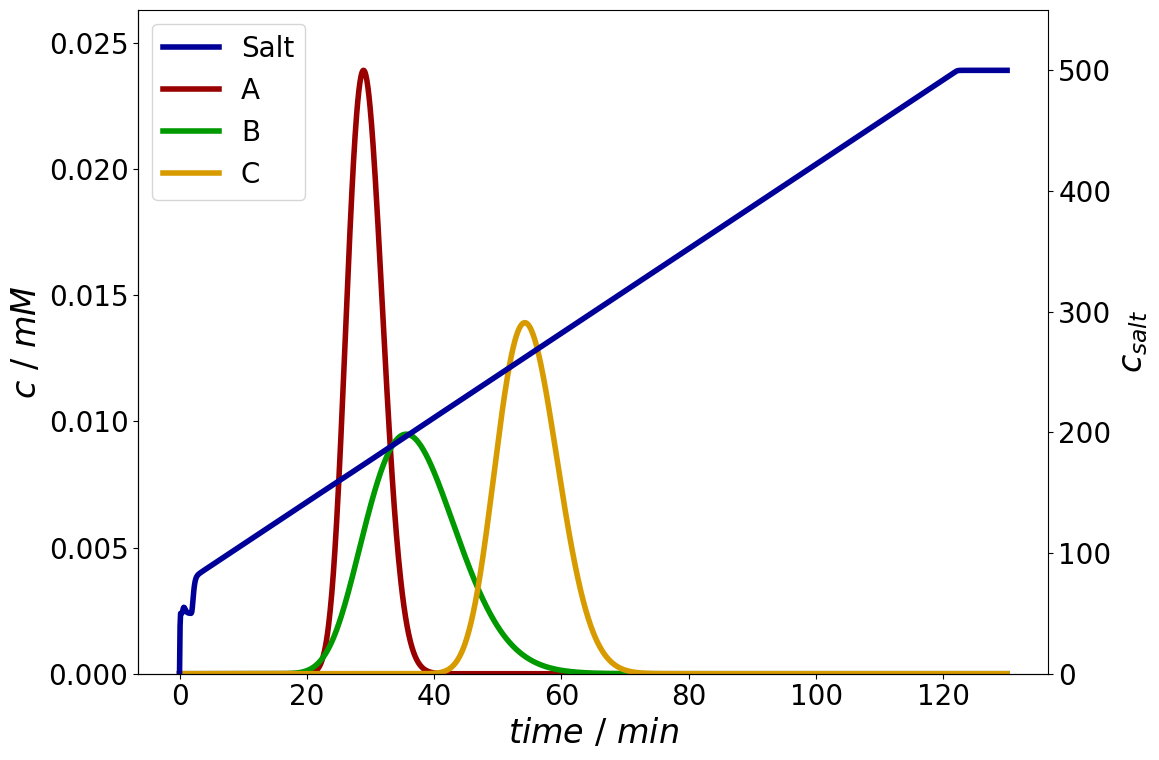

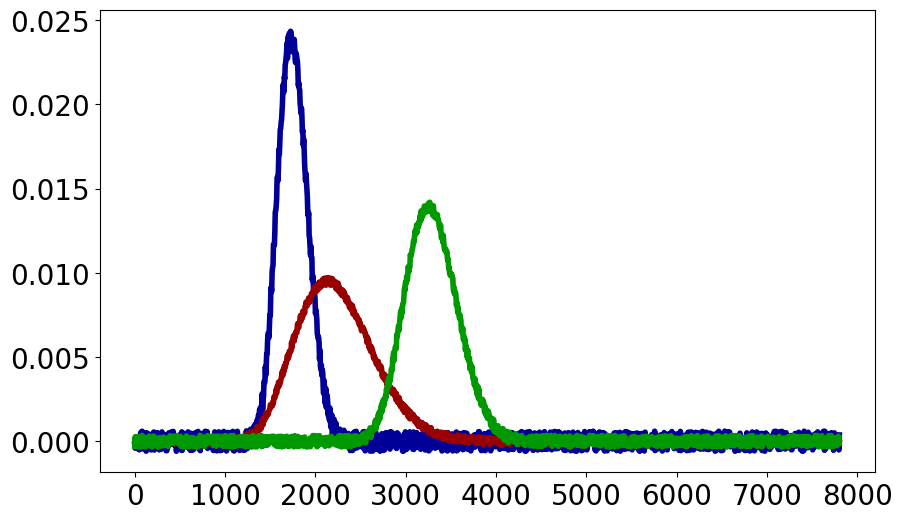

In [7]:
# Process
process = Process(flow_sheet, 'batch elution')

c_salt_load = 50
c_salt_gradient1_start = 80
c_salt_gradient1_end = 500
gradient_cv = 120
duration_gradient1 = gradient_cv * 60
process.cycle_time = duration_gradient1 + 600
t_gradient1_start = 90
t_gradient1_end = 90 + duration_gradient1
t_start_wash = 10
gradient_1_slope = (c_salt_gradient1_end - c_salt_gradient1_start)/(duration_gradient1)

c_load = [c_salt_load, 1, 1, 1]

c_wash = [c_salt_load, 0, 0, 0]

c_gradient1_poly = [
    [c_salt_gradient1_start, gradient_1_slope, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
]

process.add_duration("grad1_duration", duration_gradient1)

process.add_event('load', 'flow_sheet.inlet.c', c_load, 0)
process.add_event('wash', 'flow_sheet.inlet.c', c_wash, t_start_wash)
process.add_event('grad1_start', 'flow_sheet.inlet.c', c_gradient1_poly, t_gradient1_start)
process.add_event('grad1_end', 'flow_sheet.inlet.c', [c_salt_gradient1_end, 0, 0, 0], t_gradient1_end)

simulator = Cadet()
simulator.time_resolution = 5

# process.plot_events()

simulation_results = simulator.simulate(process)
print(simulation_results.time_elapsed)

from CADETProcess.plotting import SecondaryAxis

sec = SecondaryAxis()
sec.components = ['Salt']
sec.y_label = '$c_{salt}$'

simulation_results.solution.outlet.outlet.plot(secondary_axis=sec)
import matplotlib.pyplot as plt

plt.tight_layout()

time = simulation_results.solution.outlet.outlet.time
concentrations = simulation_results.solution.pipe2.outlet.solution
salt = simulation_results.solution.outlet.outlet.solution

concentrations = add_noise(concentrations)
salt = add_noise(salt)
concentrations[0, :] = salt[0, :]


df = pd.DataFrame(data=concentrations, index=time, columns= ["Salt [mM]", "A [mM]", "B [mM]", "C [mM]"] )
df.index.name = "time [s]"
df.to_excel(f"experimental_data/{gradient_cv}cv_gradient.xlsx")
plt.figure()
plt.plot(time, concentrations[:, 1:])

0.11604857444763184


<Axes: xlabel='time [s]'>

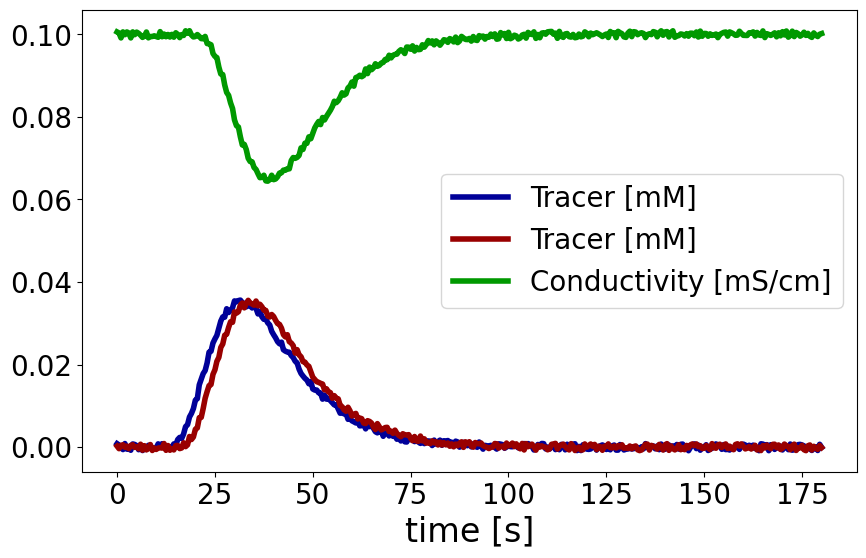

In [9]:
component_system = ComponentSystem(["Acetone"])

column = create_column(component_system)

pipe1, pipe2, pipe3 = create_pipes(component_system)

column.c = [0]
pipe1.c = [0]
pipe2.c = [0]
pipe3.c = [0]

volumetric_flow_rate = 1.67e-8

inlet = Inlet(component_system, name='inlet')
inlet.flow_rate = volumetric_flow_rate

outlet = Outlet(component_system, name='outlet')

# Flow Sheet
flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(inlet, feed_inlet=True)
flow_sheet.add_unit(pipe1)
flow_sheet.add_unit(column)
flow_sheet.add_unit(pipe2)
flow_sheet.add_unit(pipe3)
flow_sheet.add_unit(outlet, product_outlet=True)

flow_sheet.add_connection(inlet, pipe1)
flow_sheet.add_connection(pipe1, column)
flow_sheet.add_connection(column, pipe2)
flow_sheet.add_connection(pipe2, pipe3)
flow_sheet.add_connection(pipe3, outlet)

process = Process(flow_sheet, 'batch elution')

process.cycle_time = 3 * 60

process.add_event('load', 'flow_sheet.inlet.c', 1, 0)
process.add_event('wash', 'flow_sheet.inlet.c', 0, 1)
simulator = Cadet()
simulator.time_resolution = 0.5

simulation_results = simulator.simulate(process)
print(simulation_results.time_elapsed)

# simulation_results.solution.outlet.outlet.plot()
# import matplotlib.pyplot as plt

# plt.tight_layout()

time = simulation_results.solution.outlet.outlet.time
concentrations = simulation_results.solution.pipe2.outlet.solution
conductivity = simulation_results.solution.outlet.outlet.solution

concentrations1 = add_noise(concentrations)
conductivity1 = add_noise(conductivity)
conductivity1 = 0.1 - conductivity1

combined1 = np.stack([concentrations1, conductivity1], axis=1)[:, :, 0]

fig, ax = plt.subplots(1)

df = pd.DataFrame(data=concentrations1, index=time, columns= ["Tracer [mM]"] )
df.index.name = "time [s]"
df.to_excel(f"experimental_data/tracer_1.xlsx")
df.plot(ax=ax)

concentrations2 = add_noise(concentrations)
conductivity2 = add_noise(conductivity)
conductivity2 = 0.1 - conductivity2
combined2 = np.stack([concentrations2, conductivity2], axis=1)[:, :, 0]

combined2[5:, :] = combined2[:-5, :]

df = pd.DataFrame(data=combined2, index=time, columns= ["Tracer [mM]", "Conductivity [mS/cm]"] )
df.index.name = "time [s]"
df.to_excel(f"experimental_data/tracer_2.xlsx")
df.plot(ax=ax)

In [ ]:
np.stack([concentrations, conductivity], axis=1)[:, :, 0]

In [ ]:
import os
os.getcwd()